In [1]:
import geopandas as gpd
import pandas as pd
from libpysal import weights
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from concurrent.futures import ProcessPoolExecutor, as_completed


# Torch.
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx

In [2]:
from graph_helper_functions import *

In [3]:
src = os.getcwd()
proc = 'data/processed'
df = pd.read_csv(os.path.join(src, proc, 'SCALED_DATA.CSV'))

In [4]:
# Read and create a NetworkX graph from the geojson file.
us_counties = gpd.read_file(os.path.join(src, 'data/old/raw/counties.geojson')
us_counties = us_counties.to_crs(epsg=3857)
centroids = np.column_stack((us_counties.centroid.x, us_counties.centroid.y))
queen = weights.Queen.from_dataframe(us_counties, use_index=False)
graph = queen.to_networkx()
print(f"Number of nodes (i.e. counties): {len(graph.nodes)}")

Number of nodes (i.e. counties): 3108


/Users/jakecordery/Desktop/dissertation-york/.venv/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 1839, 2708.
  W.__init__(self, neighbors, ids=ids, **kw)


<Figure size 1600x1200 with 0 Axes>

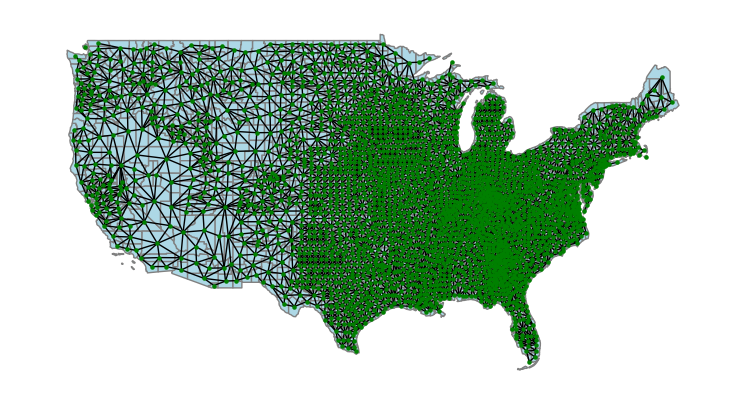

In [5]:
# Plot entire graph.
plt.figure(figsize=(16, 12)) 
positions = dict(zip(graph.nodes, centroids))
ax = us_counties.plot(linewidth=1, edgecolor='grey', facecolor='lightblue', figsize=(10, 5))
ax.axis('off')
nx.draw(graph, positions, ax=ax, node_size=5, node_color='green') # Change node color depending on the state.
#plt.savefig("results/figures/us_counties_graph_map.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [6]:
# Lower the column names.
print(us_counties.columns)
us_counties.columns = us_counties.columns.str.lower().str.strip()
print(us_counties.head(2))
us_counties['countyfips'] = us_counties['statefp'] + us_counties['countyfp']

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')
  statefp countyfp  countyns        affgeoid  geoid           name lsad  \
0      06      075  00277302  0500000US06075  06075  San Francisco   06   
1      25      025  00606939  0500000US25025  25025        Suffolk   06   

       aland     awater                                           geometry  
0  121485107  479107241  POLYGON ((-13637971.564 4547144.419, -13632785...  
1  150855462  160479920  POLYGON ((-7924963.124 5203475.069, -7921148.4...  


In [7]:
# Graph creation helper functions.
def assign_attributes(cdf, graph, attr):
    node_to_attr = dict(enumerate(cdf[attr]))
    nx.set_node_attributes(graph, node_to_attr, attr)

def filter_graph(graph, positions, node_subset):
    pos_filtered = {n: positions[n] for n in node_subset}
    return graph.subgraph(node_subset), pos_filtered

def state_graph(state_fp, state_to_node, graph=graph, showplot=False):
    """state_fp: str(int)"""
    node_subset = state_to_node[state_fp]
    graph_filtered, pos_filtered = filter_graph(graph, positions, node_subset)
    # Show the plot on the map backing.
    if showplot:
        ax = us_counties.plot(linewidth=1, edgecolor='grey', facecolor='lightblue', figsize=(10, 5))
        ax.axis('off')
        nx.draw(graph_filtered, pos=pos_filtered, ax=ax, node_size=5, node_color='green')
        plt.show()
    return graph_filtered, pos_filtered

def nx_to_pyg(G, pos, dates): # Custom function required because of the odd names of the nodes (i.e California has nodes 0, 682, 1025 etc.)
    # Rename the nodes 0:num_nodes. Key is old name, value is new name.
    nodes = {node: n for n, node in enumerate(G.nodes)}

    # Transfer graph from nx to pytorch_geometric.
    edge_index = torch.zeros((2, len(G.edges)), dtype=torch.long)
    for i, (n1, n2) in enumerate(G.edges):
        tens = torch.tensor([nodes[n1], nodes[n2]])
        edge_index[:, i] += tens # Index is unimportant here since the node, node pair is all that is needed.

    x = torch.zeros((len(nodes.keys()), len(dates)), dtype=torch.float32) # (num_nodes, num_node_features).
    i = 0 # Count through the 1st axis of the feature matrix.
    for i, date in enumerate(dates):
        if '-' not in date: # Skip if not a date.
            continue
        cases = nx.get_node_attributes(G, date) # Dictionary of all the nodes on a given day.
        cases_nn = {nodes[node]: case for node, case in cases.items()} # New node name: case.
        for node, case in cases_nn.items():
            x[node, i] += case
    
    # Order-preserving since the nodes otherwise come out randomly assigned.
    tpos = torch.zeros((len(nodes.keys()), 2)) #(num_nodes, num_dimensions).
    for i, node in enumerate(nodes.keys()):
        # Ensure pos[node] exists and convert it to a tensor.
        tpos[i, :] = torch.tensor(pos[node], dtype=torch.float32).flatten()

    return Data(x=x, edge_index=edge_index, pos=tpos)

# Create and save the state graphs - in the format statename.pt
def create_graphs(save_loc, states, state_to_node, dates, graph=graph):
    os.makedirs(save_loc, exist_ok=True)

    for state in states: # Concurrent futures?
        graph_filtered, pos_filtered = state_graph(state_fp=state, state_to_node=state_to_node)
        H = nx_to_pyg(graph_filtered, pos_filtered, dates)
        save_g_loc = os.path.join(save_loc, f"{state}.pt")
        if not os.path.exists(save_g_loc):
            torch.save(H, save_g_loc)


In [8]:
# Add fips column to allow comparisons between geojson and df.

def main(df, setname):
    df = df.rename(columns={"countyFIPS": "countyfips"})
    df = df.dropna(subset="countyfips", axis=0)

    # Remove the nodes/rows from geojson data, where counties are not in the df.
    us = us_counties.copy()

    # Seems that the rows actually need to be removed from df!
    # Force the countyfips columns to be integer.
    df['countyfips'] = df['countyfips'].astype(int)
    us['countyfips'] = us['countyfips'].astype(int)
    counties1 = set(df['countyfips'])
    counties2 = set(us['countyfips'])
    common_counties = counties1.intersection(counties2)
    df = df[df['countyfips'].isin(common_counties)]

    # Merge the dataframes
    cdf = pd.merge(us, df, on=['countyfips'], how='left')
    
    # Assign properties to the graph nodes.
    dates = list(cdf.columns[13:])
    attrs = ["countyfips"] + dates # INCLUDE THE GEOMETRY/POS OF THE COUNTY?

    for att in attrs:
        assign_attributes(cdf, graph, attr=att)
    
    # Test: ommiting every state bar one.
    # Need a dictionary with state: [fips] where the fips are the counties in the states.
    state_to_cfip = {}
    for state in cdf.statefp.unique():
        temp = cdf[cdf['statefp'] == state]
        countyfps = temp.countyfips.to_list()
        state_to_cfip[state] = countyfps

    # Need a dictionary to then convert the countyfp to the node number.
    fp_to_node = {}
    for node, data in graph.nodes(data=True):
        fp_to_node[data['countyfips']] = node

    # Now use this to filter the graph to a one-state graph.
    # state_to_fip gives the entire state's worth of fips.
    # Each individual fip can be used to build a dictionary with state to node.
    state_to_node = {}
    for statefp, countyfpss in state_to_cfip.items():
        li = [fp_to_node[cfp] for cfp in countyfpss]
        state_to_node[statefp] = li

    states = cdf.statefp.to_list()
    save_loc = f"data/processed/{setname}_graphs"
    return save_loc, states, state_to_node, dates

In [9]:
# if __name__ == "__main__":
#     traindf = pd.read_csv('/Users/jakecordery/Desktop/dissertation-york/data/processed/TRAIN_SCALED.csv')
#     save_loc, states, state_to_node, dates = main(traindf, setname='train')
#     create_graphs(save_loc, states, state_to_node, dates)

#     valdf = pd.read_csv('/Users/jakecordery/Desktop/dissertation-york/data/processed/VAL_SCALED.csv') 
#     save_loc, states, state_to_node, dates = main(valdf, setname='val')
#     create_graphs(save_loc, states, state_to_node, dates)

#     testdf = pd.read_csv('/Users/jakecordery/Desktop/dissertation-york/data/processed/TEST_SCALED.csv') 
#     save_loc, states, state_to_node, dates = main(testdf, setname='test')
#     create_graphs(save_loc, states, state_to_node, dates)


In [10]:
traindf = pd.read_csv(os.path.join(src, proc, 'LSTM/TRAIN_SCALED.csv'))
valdf = pd.read_csv(os.path.join(src, proc, 'LSTM/VAL_SCALED.csv'))
import re
non_numeric_val = [col for col in valdf.columns if not re.match(r'\d{4}-\d{2}-\d{2}', col)]
dfval_f = valdf.drop(columns=non_numeric_val, axis=0)
df = pd.concat([traindf, dfval_f], axis=1)

def shorten_df(step, df=df, min_cols=50):
    # Where step is the number of 2 month blocks in the training data.
    month = 30
    train_df = df[df.columns[:(month * 2 * step + 4)]]
    val_df = df[df.columns[(month * 2 * step + 4):(month * 2 * step + min_cols + 4)]]
    val_df = pd.concat([train_df[train_df.columns[:4]], val_df], axis=1)
    return train_df, val_df

# for step in range(8, 11):
#     traindf, valdf = shorten_df(step)
#     save_loc, states, state_to_node, dates = main(traindf, setname=f'step{step}_train')
#     create_graphs(save_loc, states, state_to_node, dates)

#     save_loc, states, state_to_node, dates = main(valdf, setname=f'step{step}_val')
#     create_graphs(save_loc, states, state_to_node, dates)

In [11]:
# Create training+val train set.
save_loc, states, state_to_node, dates = main(df, setname='train_val')
create_graphs(save_loc, states, state_to_node, dates)

In [13]:
def test_load(state: str, save_loc, ax=None):
    H = torch.load(os.path.join(save_loc, f'{state}.pt'), weights_only=False)
    G_nx = torch_geometric.utils.to_networkx(H, node_attrs=['pos'], to_undirected=True)
    pos = nx.get_node_attributes(G_nx, 'pos')

    # Now draw using the extracted positions
    if ax != None:
        nx.draw(G_nx, pos=pos, ax=ax, node_size=20, node_color='blue')
    else:
        nx.draw(G_nx, pos=pos, node_size=20, node_color='blue')

def test_load_spec(save_loc):
    test_load('06', save_loc)
    plt.show()
    test_load('12', save_loc)
    plt.show()
    test_load('48', save_loc)
    plt.show()

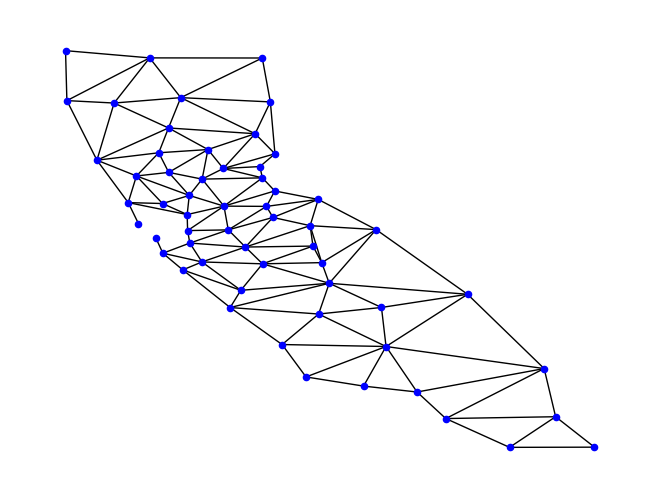

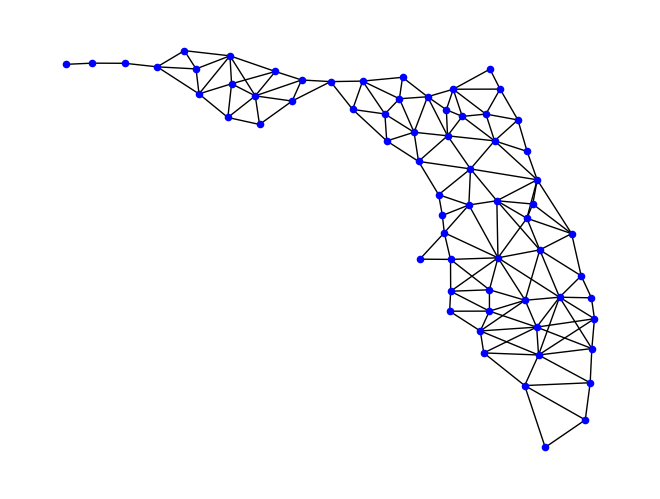

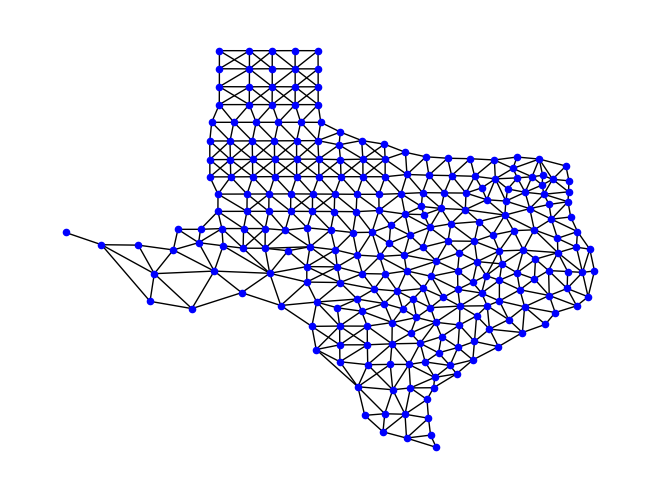

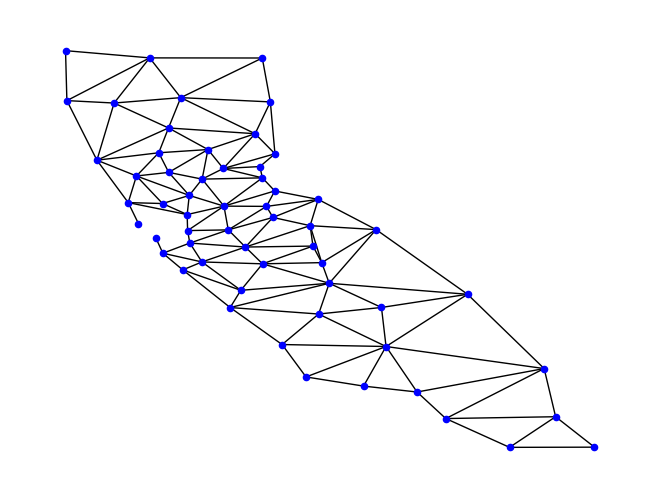

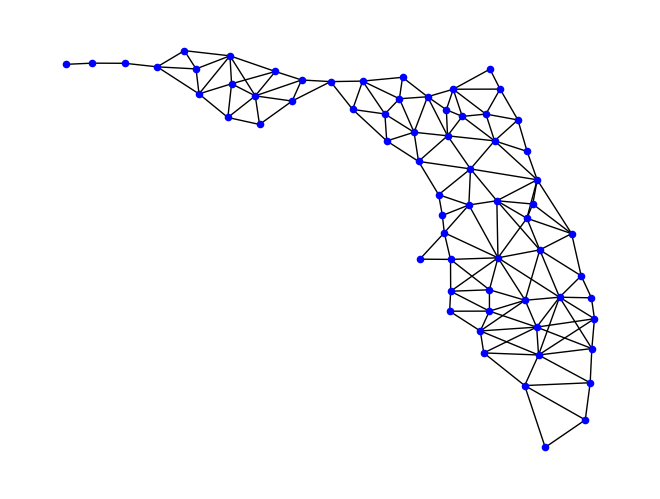

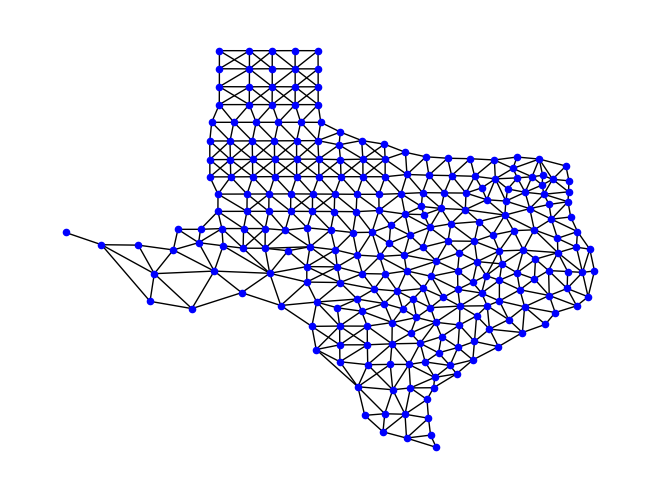

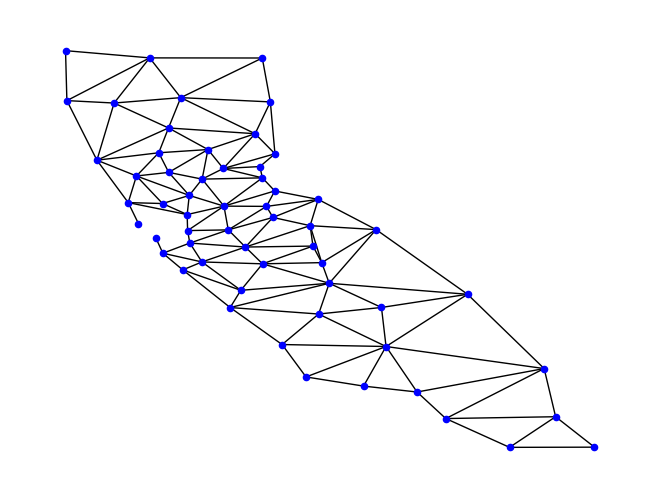

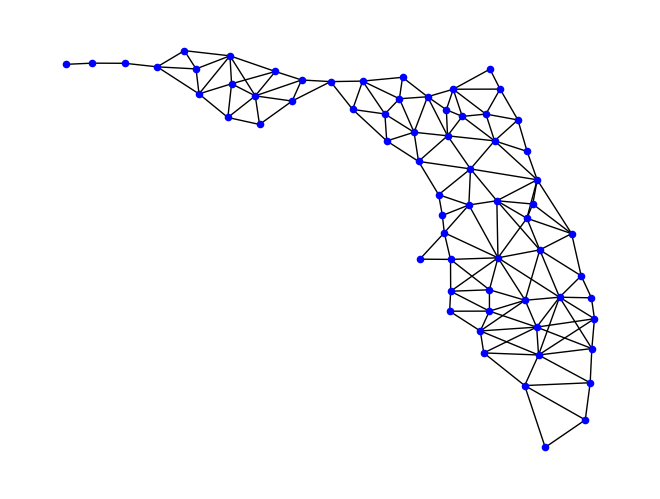

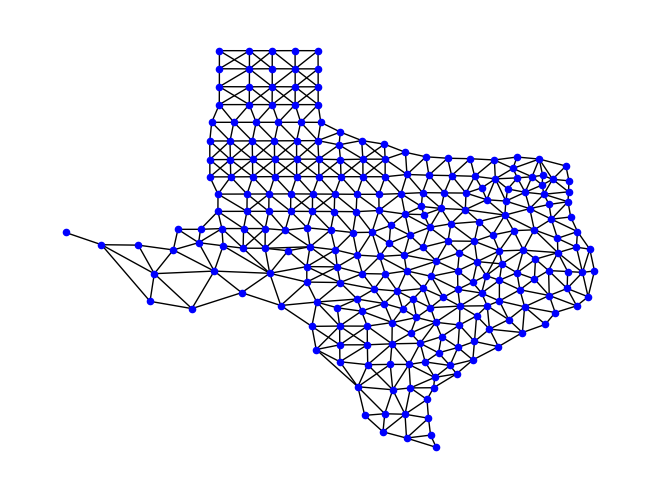

In [ ]:
test_load_spec(os.path.join(src, proc, 'train_graphs'))
test_load_spec(os.path.join(src, proc, 'val_graphs'))
test_load_spec(os.path.join(src, proc, 'test_graphs'))